

<h1 style='background-color:green; font-family:newtimeroman; font-size:180%; text-align:center; border-radius: 15px 50px;' > Parkinson Detection - Xception </h1>

### Symptoms and Diagnosis

Parkinson symptoms are different for different people. Common symptoms of Parkinson Disease include:

* tremor – shaking, which usually begins in the hand or arm and is more likely to occur when the limb is relaxed and resting
* slowness of movement (bradykinesia) – physical movements are much slower than normal, which can make everyday tasks difficult and result in a distinctive slow, shuffling walk with very small steps
* muscle stiffness (rigidity) – stiffness and tension in the muscles, which can make it difficult to move around and make facial expressions, and can result in painful muscle cramps (dystonia)
*balance problems – these can make someone with the condition more likely to have a fall and injure themselves
*problems sleeping (insomnia) – this can result in excessive sleepiness during the day


<img src="https://www.vanraam.com/getmedia/3078b293-12dd-4a5b-8bdf-028ee835bdcc/Cycling-with-Parkinson-s-disease-with-Van-Raam-special-needs-bicycles.png?width=500" width="800px">

### Description of DataBase

#### OpenNeuro Dataset ds000245

This data was obtained from the OpenfMRI database. Its accession number is ds000245.

Images were nii and we converted them to png to fit the model.
Data contains 2 folders: healthy and Parkinson Patients.
Data folder is the main folder that contain all the step folders
inside Data folder are test , train , valid

test represent testing set

train represent training set

valid represent validation set

training set is 70%

testing set is 20%

validation set is 10%


* Hyposmia

Severe hyposmia is a risk factor of dementia in Parkinson’s disease (PD), while the underlying functional connectivity (FC) and brain volume alterations in PD patients with severe
hyposmia (PD-SH) are unclear.


#### Dataset link :

[Here](https://openneuro.org/datasets/ds000245/versions/00001)


## Xception
## Xception is a deep convolutional neural network architecture that involves Depthwise Separable Convolutions.

https://iq.opengenus.org/xception-model/#:~:text=Xception%20is%20a%20deep%20convolutional,version%20of%20an%20Inception%20module.

* Xception is also known as “extreme” version of an Inception module. <br>
<img src = 'https://ars.els-cdn.com/content/image/1-s2.0-S2666285X21000583-gr6.jpg' width = 800px >

In [36]:
# import the necessary packages
!pip install imutils
!pip install wget
!pip install split-folders

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dropout,Convolution2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import splitfolders
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import wget
import cv2
import tensorflow as tf
import tensorflow_datasets.public_api as tfds

## Preprocessing

In [38]:
path = '../input/ds000245a'

In [61]:
HEIGHT = 192
WIDTH = 256
INIT_LR = 1e-4
EPOCHS =  50
BS = 32

## Image Augmentation

In [40]:
train = ImageDataGenerator(
rescale = 1/255,
horizontal_flip=True,
vertical_flip=True,
shear_range=0.2,
zoom_range=0.2,
featurewise_center=True, # Set input mean to 0 over the dataset, feature-wise
featurewise_std_normalization=True, # Divide inputs by std of the dataset, feature-wise
rotation_range=40, # Degree range for random rotations
width_shift_range=0.2,
height_shift_range=0.2,
fill_mode='nearest')

In [41]:
val = ImageDataGenerator(
rescale = 1/255)

In [42]:
os.makedirs('preview')

FileExistsError: [Errno 17] File exists: 'preview'

In [43]:
imagePaths = list(paths.list_images(path))

In [44]:
img = load_img(imagePaths[50])  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train.flow(x, batch_size=1,save_to_dir='preview', save_prefix='yh', save_format='jpeg'):
    i += 1
    if i > 10:
        break  # otherwise the generator would loop indefinitely

## Samples Visualization

(192, 256, 3)

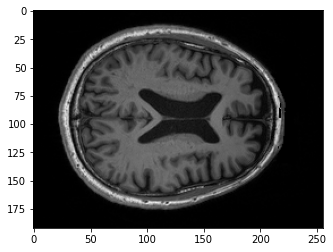

In [45]:
image = cv2.imread(imagePaths[50])
plt.imshow(image)
image.shape

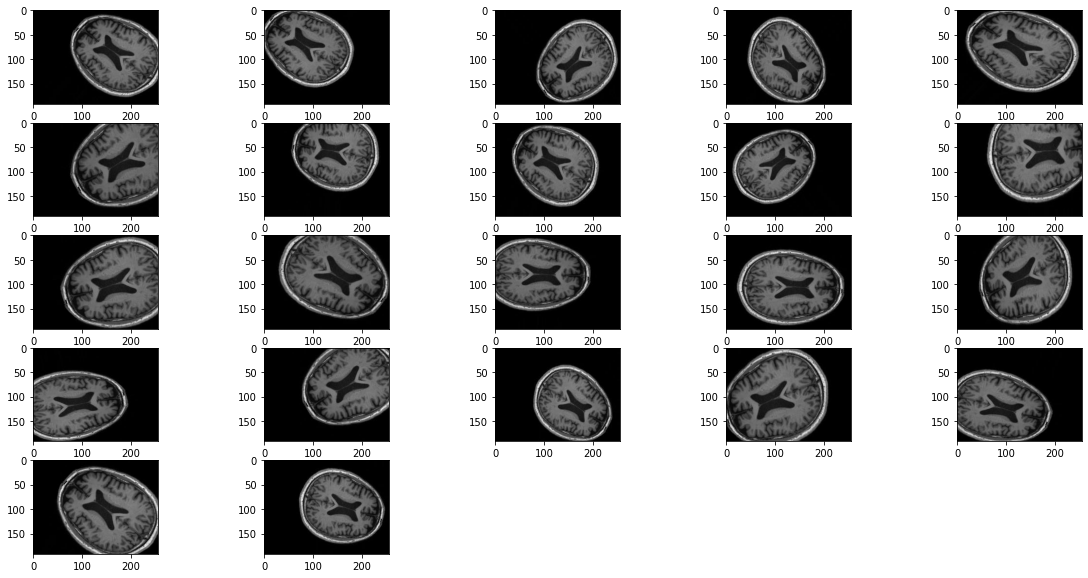

In [46]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('preview/*.jpeg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

## Splitting into Train and Validation Set

In [62]:
trainset = train.flow_from_directory("../input/ds000245a/data2/train",
target_size = (WIDTH,HEIGHT),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
class_mode='categorical')

Found 340 images belonging to 2 classes.


In [63]:
validset = val.flow_from_directory("../input/ds000245a/data2/validation",
target_size = (WIDTH,HEIGHT),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
class_mode='categorical')

Found 68 images belonging to 2 classes.


In [49]:
trainset.class_indices

{'healthy': 0, 'pd': 1}

## Model Architecture - Xception

In [64]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(WIDTH, HEIGHT, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output

headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(trainset.num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
#sgd = SGD(lr=INIT_LR,momentum=0.9,nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer='Adam',metrics=["accuracy"])
# train the head of the network

[INFO] compiling model...


In [65]:
# Model Summary

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 95, 32)  864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 95, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 95, 32)  0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

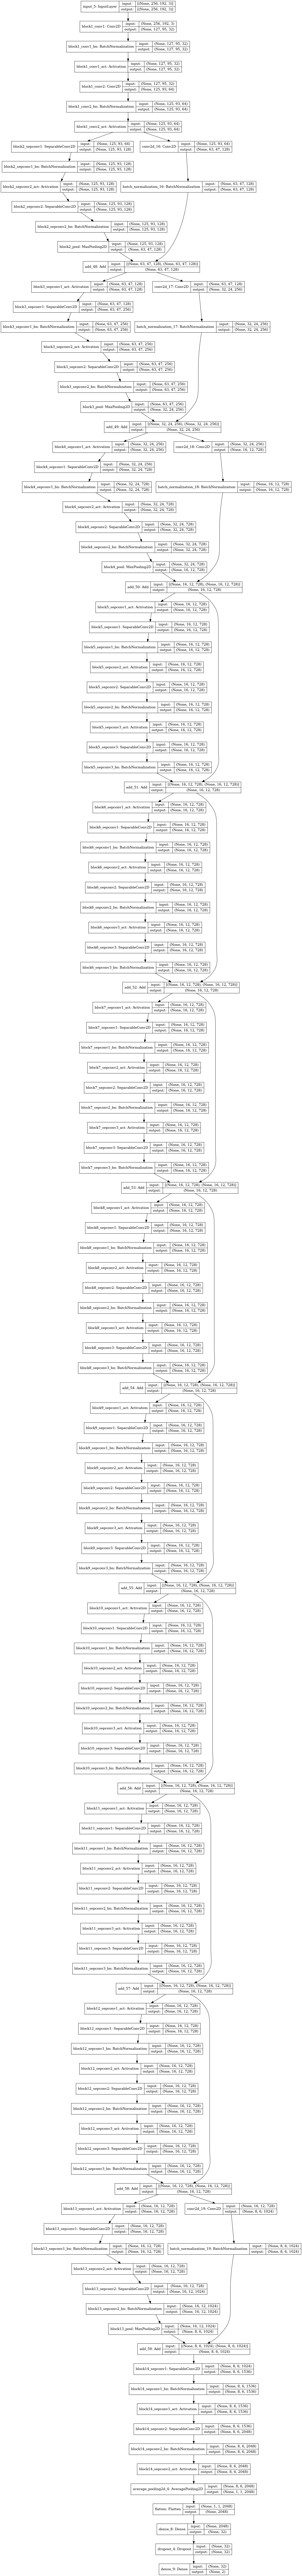

In [66]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

## Train Results

In [67]:
from keras.callbacks import ModelCheckpoint


In [68]:
# Fine-tune the pretrained Inception V3 model using the data generator
# Specify steps per epoch (number of samples/batch_size)
#checkpoint_filepath = '/content/drive/MyDrive/ds000245/data2'
mc = ModelCheckpoint('./best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit_generator(
    trainset,
    epochs=50, validation_data=validset, 
    callbacks=[mc])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
11/11 [==============================] - 8s 514ms/step - loss: 0.9772 - accuracy: 0.4265 - val_loss: 0.7608 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ./best_model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
11/11 [==============================] - 4s 405ms/step - loss: 0.7887 - accuracy: 0.4000 - val_loss: 0.6981 - val_accuracy: 0.5294

Epoch 00002: val_accuracy improved from 0.50000 to 0.52941, saving model to ./best_model.h5
Epoch 3/50
11/11 [==============================] - 4s 401ms/step - loss: 0.7115 - accuracy: 0.3500 - val_loss: 0.6868 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.52941
Epoch 4/50
11/11 [==============================] - 5s 405ms/step - loss: 0.6922 - accuracy: 0.4794 - val_loss: 0.6867 - val_accuracy: 0.6324

Epoch 00004: val_accuracy improved from 0.52941 to 0.63235, saving model to ./best_model.h5
Epoch 5/50
11/11 [==============================] - 4s 392ms/step - loss: 0.6941 - accuracy: 0.4853 - val_loss: 0.6890 - val_accuracy: 0.7059

Epoch 00005: val_accuracy improved from 0.63235 to 0.70588, saving model to ./best_model.h5
Epoch 6/50
11/11 [==============================] - 5s 464ms/step - loss: 0.6924 - accuracy: 0.53

## Results Plot

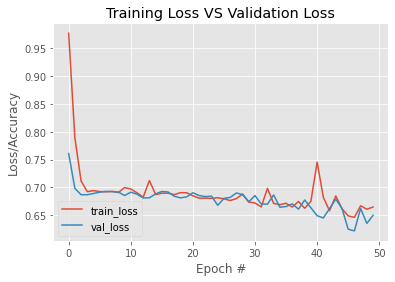

<Figure size 432x288 with 0 Axes>

In [69]:
# plot the training loss and accuracy
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss VS Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('graph.png')

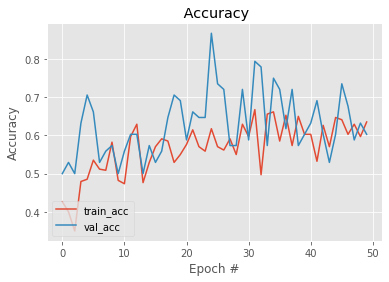

In [70]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title(" Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

## precision    recall  f1-score   support

In [71]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
validset.reset()
predIdxs = model.predict(x=validset)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(validset.classes, predIdxs,
	target_names=validset.class_indices.keys()))
# serialize the model to disk
print("[INFO] serializing network...")
model.save('logo.model', save_format="h5")

[INFO] evaluating after fine-tuning network...
              precision    recall  f1-score   support

     healthy       1.00      0.21      0.34        34
          pd       0.56      1.00      0.72        34

    accuracy                           0.60        68
   macro avg       0.78      0.60      0.53        68
weighted avg       0.78      0.60      0.53        68

[INFO] serializing network...


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Some Predictions from Test Set

In [83]:
testimage = list(paths.list_images('../input/ds000245a/data2/test/healthy'))

In [84]:
model.get_config

<bound method Functional.get_config of <keras.engine.functional.Functional object at 0x7f7dcb025d50>>

In [85]:
from PIL import Image
def predimage(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.axis("off")
    test = load_img(path,target_size=(WIDTH,HEIGHT))
    test = img_to_array(test)
    test = np.expand_dims(test,axis=0)
    test /= 255 
    result = model.predict(test,batch_size = BS)
    y_class = result.argmax(axis=-1)
    result = (result*100)
    result = list(np.around(np.array(result),1))
    print(result)
    y = list(trainset.class_indices.keys())
    print(y[y_class[0]])

[array([53.2, 46.8], dtype=float32)]
healthy


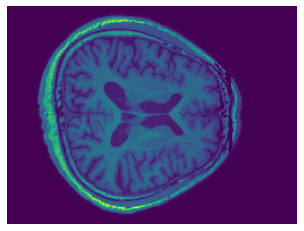

In [86]:
predimage(imagePaths[122])

[array([51., 49.], dtype=float32)]
healthy


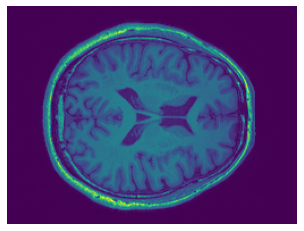

In [91]:
predimage(imagePaths[110])

In [92]:
testimage2 = list(paths.list_images('../input/ds000245a/data2/test/pd'))

In [93]:
from PIL import Image
def predimage(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.axis("off")
    test = load_img(path,target_size=(WIDTH,HEIGHT))
    test = img_to_array(test)
    test = np.expand_dims(test,axis=0)
    test /= 255 
    result = model.predict(test,batch_size = BS)
    y_class = result.argmax(axis=-1)
    result = (result*100)
    result = list(np.around(np.array(result),1))
    print(result)
    y = list(trainset.class_indices.keys())
    print(y[y_class[0]])

[array([36.4, 63.6], dtype=float32)]
pd


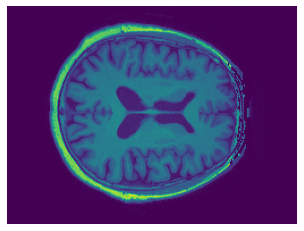

In [94]:
predimage(imagePaths[55])

[array([47.1, 52.9], dtype=float32)]
pd


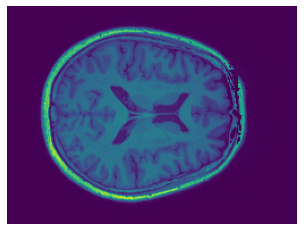

In [96]:
predimage(imagePaths[32])

[array([41.1, 58.9], dtype=float32)]
pd


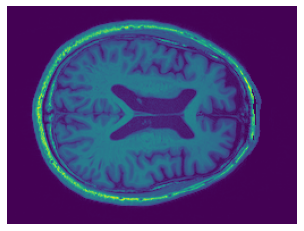

In [97]:
predimage(imagePaths[46])

[array([43.7, 56.3], dtype=float32)]
pd


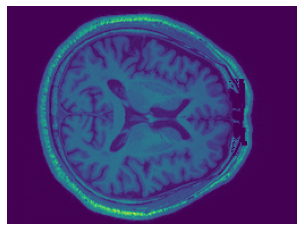

In [98]:
predimage(imagePaths[78])